In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
# import clip
import open_clip
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import os
from uuid import uuid4
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class AIGIDataset(Dataset):
#     def __init__(self, csv_file, img_dir, transform=None):
    def __init__(self, data_df, img_dir, transform=None):
        """
        Args:
            csv_file (str): Path to CSV file with image paths, prompts, and MOS scores.
            img_dir (str): Directory containing images.
            transform: Image transformations.
        """
#         self.data = pd.read_csv(csv_file)
        self.data = data_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx]["name"])
        image = Image.open(img_name).convert("RGB")
        
        # Initial prompt
        initial_prompt = self.data.iloc[idx]["prompt"]
        
        # MOS score (quality score)
        mos_score = float(self.data.iloc[idx]["mos_quality"])
        # print(mos_score)
        if self.transform:
            image = self.transform(image)
        
        return {
            "image": image,
            "initial_prompt": initial_prompt,
            "mos_score": mos_score
        }

# Image patch extraction
def extract_patches(image, patch_size=112, stride=56):
    """
    Extract patches from an image.
    Args:
        image (Tensor): Input image [C, H, W].
        patch_size (int): Size of each patch.
        stride (int): Stride for patch extraction.
    Returns:
        List of patches.
    """
    patches = []
#     print(image.shape) (1,3,224,224)
    _, _, h, w = image.shape
    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = image[:,:, i:i+patch_size, j:j+patch_size]
            patches.append(patch)
    # print(f"Extracted {len(patches)} patches of size {patch_size}x{patch_size} from image.")
    return patches

# Task-specific prompt construction
def construct_task_specific_prompts():
    """
    Construct task-specific prompts for alignment and perception quality.
    Returns:
        Dictionary with alignment and perception prompts.
    """
    alignment_adverbs = ["badly", "poorly", "fairly", "well", "perfectly"]
    perception_adjectives = ["bad", "poor", "fair", "good", "perfect"]
    perception_antonyms = ["bad","good","perfect"]
    
    alignment_prompts = [f"A photo that {adv} matches {{pt}}." for adv in alignment_adverbs]
    perception_prompts_1 = [f"A photo of {adj} quality." for adj in perception_adjectives]
    perception_prompts_2=[f"{ant} photo." for ant in perception_antonyms]
    return {
        "alignment": alignment_prompts,
        "perception_adjective": perception_prompts_1,
        "perception_antonym": perception_prompts_2
        
    }



In [2]:
# TSP-MGS Model
class TSPMGS(nn.Module):
    def __init__(self, clip_model, num_quality_levels=5, alpha=0.5):
        super(TSPMGS, self).__init__()
        self.clip_model = clip_model
        self.num_quality_levels = num_quality_levels
        self.alpha = alpha
        self.num_quality_levels_ant = 3
        #added code
        # Add resize transform for patches
        self.patch_resize = transforms.Resize((224, 224))
        
    def forward(self, images, patches_list, task_prompts, initial_prompts):
        """
        Args:
            images (Tensor): Batch of resized images [B, C, H, W].
            patches_list (List): List of patch tensors for each image.
            task_prompts (Dict): Task-specific prompts tokenized.
            initial_prompts (List): Initial prompts for images.
        Returns:
            Predicted quality scores.
        """
        # Extract image and patch features
        image_features = self.clip_model.encode_image(images).float()
        patch_features = []

        for batch_patches in patches_list:  # Shape: [36, 3, 64, 64]
            # Resize all 36 patches in the batch at once
            resized_patches = torch.stack([self.patch_resize(patch) for patch in batch_patches])  # Shape: [36, 3, H', W']

            # Encode all resized patches
            patch_feats = torch.stack([self.clip_model.encode_image(patch).float() for patch in resized_patches])  # [36, D]

            # Mean over patches
            patch_feats = patch_feats.mean(dim=0)  # [D]

            patch_features.append(patch_feats)

        patch_features = torch.stack(patch_features).float()  # Final shape: [B, D]
        # print("This is the shape of the patch features",patch_features.shape)
                
        # Extract text features
        align_prompt_feats = self.clip_model.encode_text(task_prompts["alignment"]).float()
        percep_prompt_feats = self.clip_model.encode_text(task_prompts["perception_adjective"]).float()
        percep_antonym_prompt_feats = self.clip_model.encode_text(task_prompts["perception_antonym"]).float()
        
        # Tokenize initial prompts and extract word-level features
        initial_tokens = open_clip.tokenize(initial_prompts).to(device)
        with torch.no_grad():
            #text_outputs = self.clip_model.text_model(initial_tokens)
            text_outputs = self.clip_model.encode_text(initial_tokens)
            word_features = text_outputs  # Word-level embeddings
#             print('These are the word_Features',word_features.shape)
            word_mask = (initial_tokens != 0).float()
#         with torch.no_grad():
#             try:
#                 # Try to get word-level features
#                 text_outputs = self.clip_model.encode_text(initial_tokens, output_hidden_states=True)
#                 word_features = text_outputs.hidden_states[-1]  # [batch_size, seq_len, hidden_dim]
#                 word_mask = (initial_tokens != 0).float()
#             except Exception as e:
#                 # Fallback to sentence-level features if hidden states are not supported
#                 print(f"Warning: Failed to extract word-level features ({e}). Using sentence-level features.")
#                 word_features = self.clip_model.encode_text(initial_tokens).float()
#                 word_features = word_features.unsqueeze(1).repeat(1, initial_tokens.size(1), 1)  # [batch_size, seq_len, hidden_dim]
#                 word_mask = (initial_tokens != 0).float()
        
        # Coarse-grained similarity
        def compute_coarse_similarity(img_feats, txt_feats):
            #print('This is the shape of img_feats',img_feats.shape) #[2,512]
            #print('This is the shape of text_feats',txt_feats.shape) # [5,512]
            
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
            txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
            similarities = img_feats @ txt_feats.T
            probs = torch.softmax(similarities, dim=-1)
            
            #print('THis is the shape fo the probs in coarse grain ', probs.shape) 
            return probs, similarities
        
        #print("---ALignment---")
        # Alignment coarse-grained
        align_img_probs, align_img_sims = compute_coarse_similarity(image_features, align_prompt_feats)
        align_patch_probs, align_patch_sims = compute_coarse_similarity(patch_features, align_prompt_feats)
        
        #print('--------Perception--------')
        
        # Perception coarse-grained
        percep_img_probs, percep_img_sims = compute_coarse_similarity(image_features, percep_prompt_feats)
        percep_patch_probs, percep_patch_sims = compute_coarse_similarity(patch_features, percep_prompt_feats)
        
        percep_img_probs_antonym, percep_img_sims_antonym = compute_coarse_similarity(image_features, percep_antonym_prompt_feats)
        percep_patch_probs_antonym, percep_patch_sims_antonym = compute_coarse_similarity(patch_features, percep_antonym_prompt_feats)
#         Fine-grained similarity
        def compute_fine_similarity(img_feats, prompt_feats):
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)         # [B, D]
            prompt_feats = prompt_feats / prompt_feats.norm(dim=-1, keepdim=True)  # [B, D]
            similarities = (img_feats * prompt_feats).sum(dim=1)                 # [B]
            return similarities

#         def compute_fine_similarity(img_feats, txt_feats):
#             img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
#             txt_feats = txt_feats / txt_feats.norm(dim=-1, keepdim=True)
#             similarities = (img_feats @ txt_feats.T).diagonal()  # [batch_size]
#             return similarities
        # print("This is the shape of the image features",image_features.shape)
        # print("This is the shape of the patch features",patch_features.shape)
        # print("This is the shape of the word features",word_features.shape)
        img_word_sim = compute_fine_similarity(image_features, word_features)
        # print("Patch features",patch_features.shape)
        # print("word features",word_features.shape)
        patch_word_sim = compute_fine_similarity(patch_features.squeeze(1), word_features)
        
        # Quality regression
        def compute_quality_score(probs, is_patch=False):
            quality_levels = torch.arange(1, self.num_quality_levels + 1, device=device).float()
            score = (self.num_quality_levels / (self.num_quality_levels - 1)) * (
                (probs * quality_levels).sum(dim=-1) - 1
            )
            return score
        def compute_quality_score_2(probs, is_patch=False):
            quality_levels = torch.arange(1, self.num_quality_levels_ant + 1, device=device).float()
            score = (self.num_quality_levels_ant / (self.num_quality_levels_ant - 1)) * (
                (probs * quality_levels).sum(dim=-1) - 1
            )
            return score
        
        # Coarse-grained scores
        Q_cg_I_align = compute_quality_score(align_img_probs)
        Q_cg_P_align = compute_quality_score(align_patch_probs, is_patch=True)
        Q_cg_I_percep = compute_quality_score(percep_img_probs)
        Q_cg_P_percep = compute_quality_score(percep_patch_probs, is_patch=True)
        Q_cg_I_percep_antonym = compute_quality_score_2(percep_img_probs_antonym)
        Q_cg_P_percep_antonym = compute_quality_score_2(percep_patch_probs_antonym, is_patch=True)
        # print("Image word similarity",img_word_sim.shape)
        # print("Patch word similarity",patch_word_sim.shape)
        # Fine-grained score
        Q_cg_I=(Q_cg_I_align + Q_cg_I_percep + Q_cg_I_percep_antonym)/3
        Q_cg_P=(Q_cg_P_align + Q_cg_P_percep + Q_cg_P_percep_antonym)/3
        Q_cg_P=Q_cg_P.squeeze(1)
        Q_fg = ((img_word_sim + patch_word_sim) / 2) * self.num_quality_levels
        # print("This is the shape of the fine-grained score",Q_fg.shape)
        # print("This is the shape of the coarse-grained score",Q_cg_I.shape)
        # print("This is the shape of the coarse-grained score",Q_cg_P.shape)

        # Normalize fine-grained score
        # Final quality score
        # Q_align = self.alpha * Q_cg_I_align + (1 - self.alpha) * Q_cg_P_align + Q_fg
        # Q_percep = self.alpha * Q_cg_I_percep + (1 - self.alpha) * Q_cg_P_percep + Q_fg
        # Q_percep_antonym = self.alpha * Q_cg_I_percep_antonym + (1 - self.alpha) * Q_cg_P_percep_antonym + Q_fg
        # Average alignment and perception for final score (as per AGIQA-1K)
        # Q_final = (Q_align + Q_percep+Q_percep_antonym) / 3
        Q_final =self.alpha * Q_cg_I + (1 - self.alpha) * Q_cg_P + Q_fg
        # print("This is the shape of the final quality score",Q_final.shape)
        return Q_final

In [3]:
from tqdm import tqdm

# Training function with tqdm
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, task_prompts):
    """
    Train the TSP-MGS model.
    """
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        
        # Wrap the loader with tqdm for progress bar
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
            images = batch["image"].to(device)
            initial_prompts = batch["initial_prompt"]
            mos_scores = batch["mos_score"].to(device).float()
            # print("This is the shape of the images",images.shape)
            # Extract patches
            # patches_list = [extract_patches(img.unsqueeze(0), patch_size=64, stride=32) for img in images]
            # print("This is the length of the patches list",len(patches_list))
            # patches_list = [[p.to(device) for p in patches] for patches in patches_list]
            patches_l = [extract_patches(img.unsqueeze(0), patch_size=64, stride=32) for img in images]
            # Each item is a list of 36 patches, shape [N, C, H, W]
            patches_tensor = torch.stack([torch.stack(patches) for patches in patches_l])  # shape: [B, N, C, H, W]
            patches_list = patches_tensor.to(device)

            # print("This is the shape of the patches list",len(patches_list))
            # print("This is the shape of the patches list",patches_list[0][32].shape)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images, patches_list, task_prompts, initial_prompts)
            
            # Compute loss
            loss = criterion(outputs, mos_scores)
            # print("loss",loss.item())
            # Backward and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
    
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        # Step scheduler
        scheduler.step()
    torch.save(model.state_dict(), "tsp_mgs_model.pth")
    print("Model saved as tsp_mgs_model.pth")
    return model

In [53]:
# Main function
# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 5e-6
weight_decay = 5e-4
image_size = 224
alpha = 1  # Balance parameter

# Image transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                       std=[0.26862954, 0.26130258, 0.27577711])
])

data_df = pd.read_csv("./AIGIQA-3k/AIGIQA-3k/data.csv")
print(data_df.columns)
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

print("Training samples:", len(train_df))
print("Testing samples:", len(test_df))


# Load datasets (replace with your paths)
train_dataset = AIGIDataset(
    #csv_file="./AIGIQA-3k/AIGIQA-3k/data.csv",  # Columns: image_name, prompt, mos_score
    data_df = train_df,
    img_dir=r"AIGIQA-3k/AIGIQA-3k/AGIQA-3K",
    transform=transform
)
test_dataset = AIGIDataset(
    #csv_file="./AIGIQA-3k/AIGIQA-3k/data.csv",
    data_df = test_df,
    img_dir=r"AIGIQA-3k/AIGIQA-3k/AGIQA-3K",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Load CLIP model
# clip_model, preprocess = clip.load("ViT-B/32", device=device)


# Load CLIP model
clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai", device=device)

# Initialize TSP-MGS model
model = TSPMGS(clip_model, num_quality_levels=5, alpha=alpha).to(device)


Index(['name', 'prompt', 'adj1', 'adj2', 'style', 'mos_quality', 'std_quality',
       'mos_align', 'std_align'],
      dtype='object')
Training samples: 2385
Testing samples: 597


In [5]:
# Optimizer and scheduler
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

# Loss function
criterion = nn.L1Loss()  # MAE as per paper

# Construct task-specific prompts
task_prompt_templates = construct_task_specific_prompts()
# Tokenize task-specific prompts
task_prompts = {
    "alignment": open_clip.tokenize(task_prompt_templates["alignment"]).to(device),
    "perception_adjective": open_clip.tokenize(task_prompt_templates["perception_adjective"]).to(device),
    "perception_antonym": open_clip.tokenize(task_prompt_templates["perception_antonym"]).to(device)
}



In [6]:
# Train model
print("Starting training...")
trained_model=train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, task_prompts)


Starting training...

Epoch [1/10]


Training Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.5492

Epoch [2/10]


Epoch [2/10], Loss: 0.3150

Epoch [3/10]


Epoch [3/10], Loss: 0.2556

Epoch [4/10]


Epoch [4/10], Loss: 0.2008

Epoch [5/10]


Epoch [5/10], Loss: 0.1630

Epoch [6/10]


Epoch [6/10], Loss: 0.1345

Epoch [7/10]


Epoch [7/10], Loss: 0.1072

Epoch [8/10]


Epoch [8/10], Loss: 0.0835

Epoch [9/10]


Epoch [9/10], Loss: 0.0659

Epoch [10/10]


Epoch [10/10], Loss: 0.0548
Model saved as tsp_mgs_model.pth


In [57]:
from scipy.stats import spearmanr, pearsonr

def test_model(model, test_loader, task_prompts):
    model.eval()
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            initial_prompts = batch["initial_prompt"]
            mos_scores = batch["mos_score"].to(device).float()

            # Patch extraction
            patches_l = [extract_patches(img.unsqueeze(0), patch_size=64, stride=32) for img in images]
            patches_tensor = torch.stack([torch.stack(patches) for patches in patches_l]).to(device)

            outputs = model(images, patches_tensor, task_prompts, initial_prompts)

            # Ensure shape: [batch]
            outputs = outputs.view(-1).cpu().numpy()
            mos_scores = mos_scores.view(-1).cpu().numpy()

            predictions.extend(outputs)
            ground_truths.extend(mos_scores)

    # Convert to numpy arrays
    predictions = np.array(predictions)
    ground_truths = np.array(ground_truths)

    # Calculate correlations
    srcc = spearmanr(predictions, ground_truths).correlation
    plcc = pearsonr(predictions, ground_truths)[0]

    return srcc, plcc, predictions, ground_truths
# Test the model
print("Testing the model...")
srcc, plcc, predictions, ground_truths = test_model(trained_model, test_loader, task_prompts)
print(f"SRCC: {srcc:.4f}, PLCC: {plcc:.4f}")

Testing the model...
SRCC: 0.8837, PLCC: 0.9117


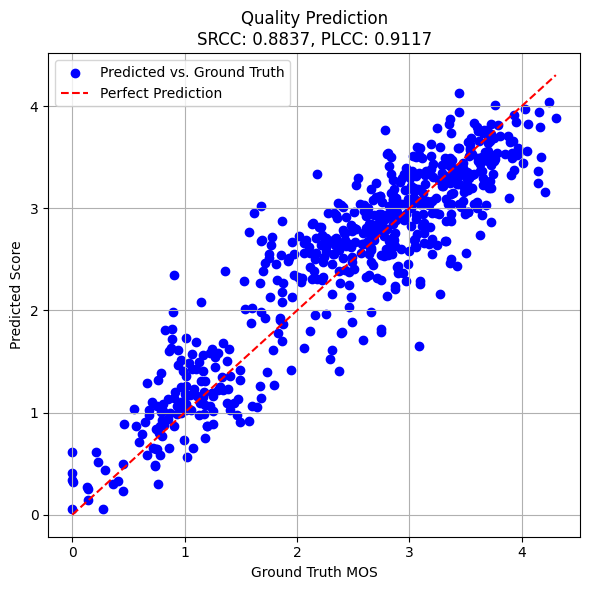

In [58]:
import matplotlib.pyplot as plt

# Run test
# srcc, plcc, predictions, ground_truths = test_model(model, test_loader, task_prompts)
# print(f"SRCC: {srcc:.4f}, PLCC: {plcc:.4f}")

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(ground_truths, predictions, c='blue', label='Predicted vs. Ground Truth')
plt.plot([min(ground_truths), max(ground_truths)], [min(ground_truths), max(ground_truths)],
         'r--', label='Perfect Prediction')
plt.xlabel('Ground Truth MOS')
plt.ylabel('Predicted Score')
plt.title(f'Quality Prediction\nSRCC: {srcc:.4f}, PLCC: {plcc:.4f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
import torch
import matplotlib.pyplot as plt

def predict_8_samples_subplot(model, test_loader, task_prompts):
    model.eval()
    images_to_show = []
    predictions = []
    ground_truths = []
    max_samples = 8

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            initial_prompts = batch["initial_prompt"]
            mos_scores = batch["mos_score"].to(device).float()
            
            # Extract patches
            patches_l = [extract_patches(img.unsqueeze(0), patch_size=64, stride=32) for img in images]
            patches_tensor = torch.stack([torch.stack(patches) for patches in patches_l]).to(device)

            outputs = model(images, patches_tensor, task_prompts, initial_prompts)

            # Squeeze if shape is [B, 1]
            if outputs.dim() > 1 and outputs.shape[1] == 1:
                outputs = outputs.squeeze(1)

            for i in range(images.size(0)):
                if len(images_to_show) >= max_samples:
                    break
                images_to_show.append(images[i].cpu().permute(1, 2, 0).numpy())
                predictions.append(float(outputs[i]))
                ground_truths.append(float(mos_scores[i]))

            if len(images_to_show) >= max_samples:
                break

    # Plot in a 2x4 grid
    fig, axes = plt.subplots(2, 4, figsize=(20,15))
    fig.suptitle("Predicted vs Ground Truth MOS Scores", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(images_to_show):
            ax.imshow(images_to_show[i])
            ax.set_title(f"Predicted: {predictions[i]:.2f}\nGroundTruth: {ground_truths[i]:.2f}", fontsize=35)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

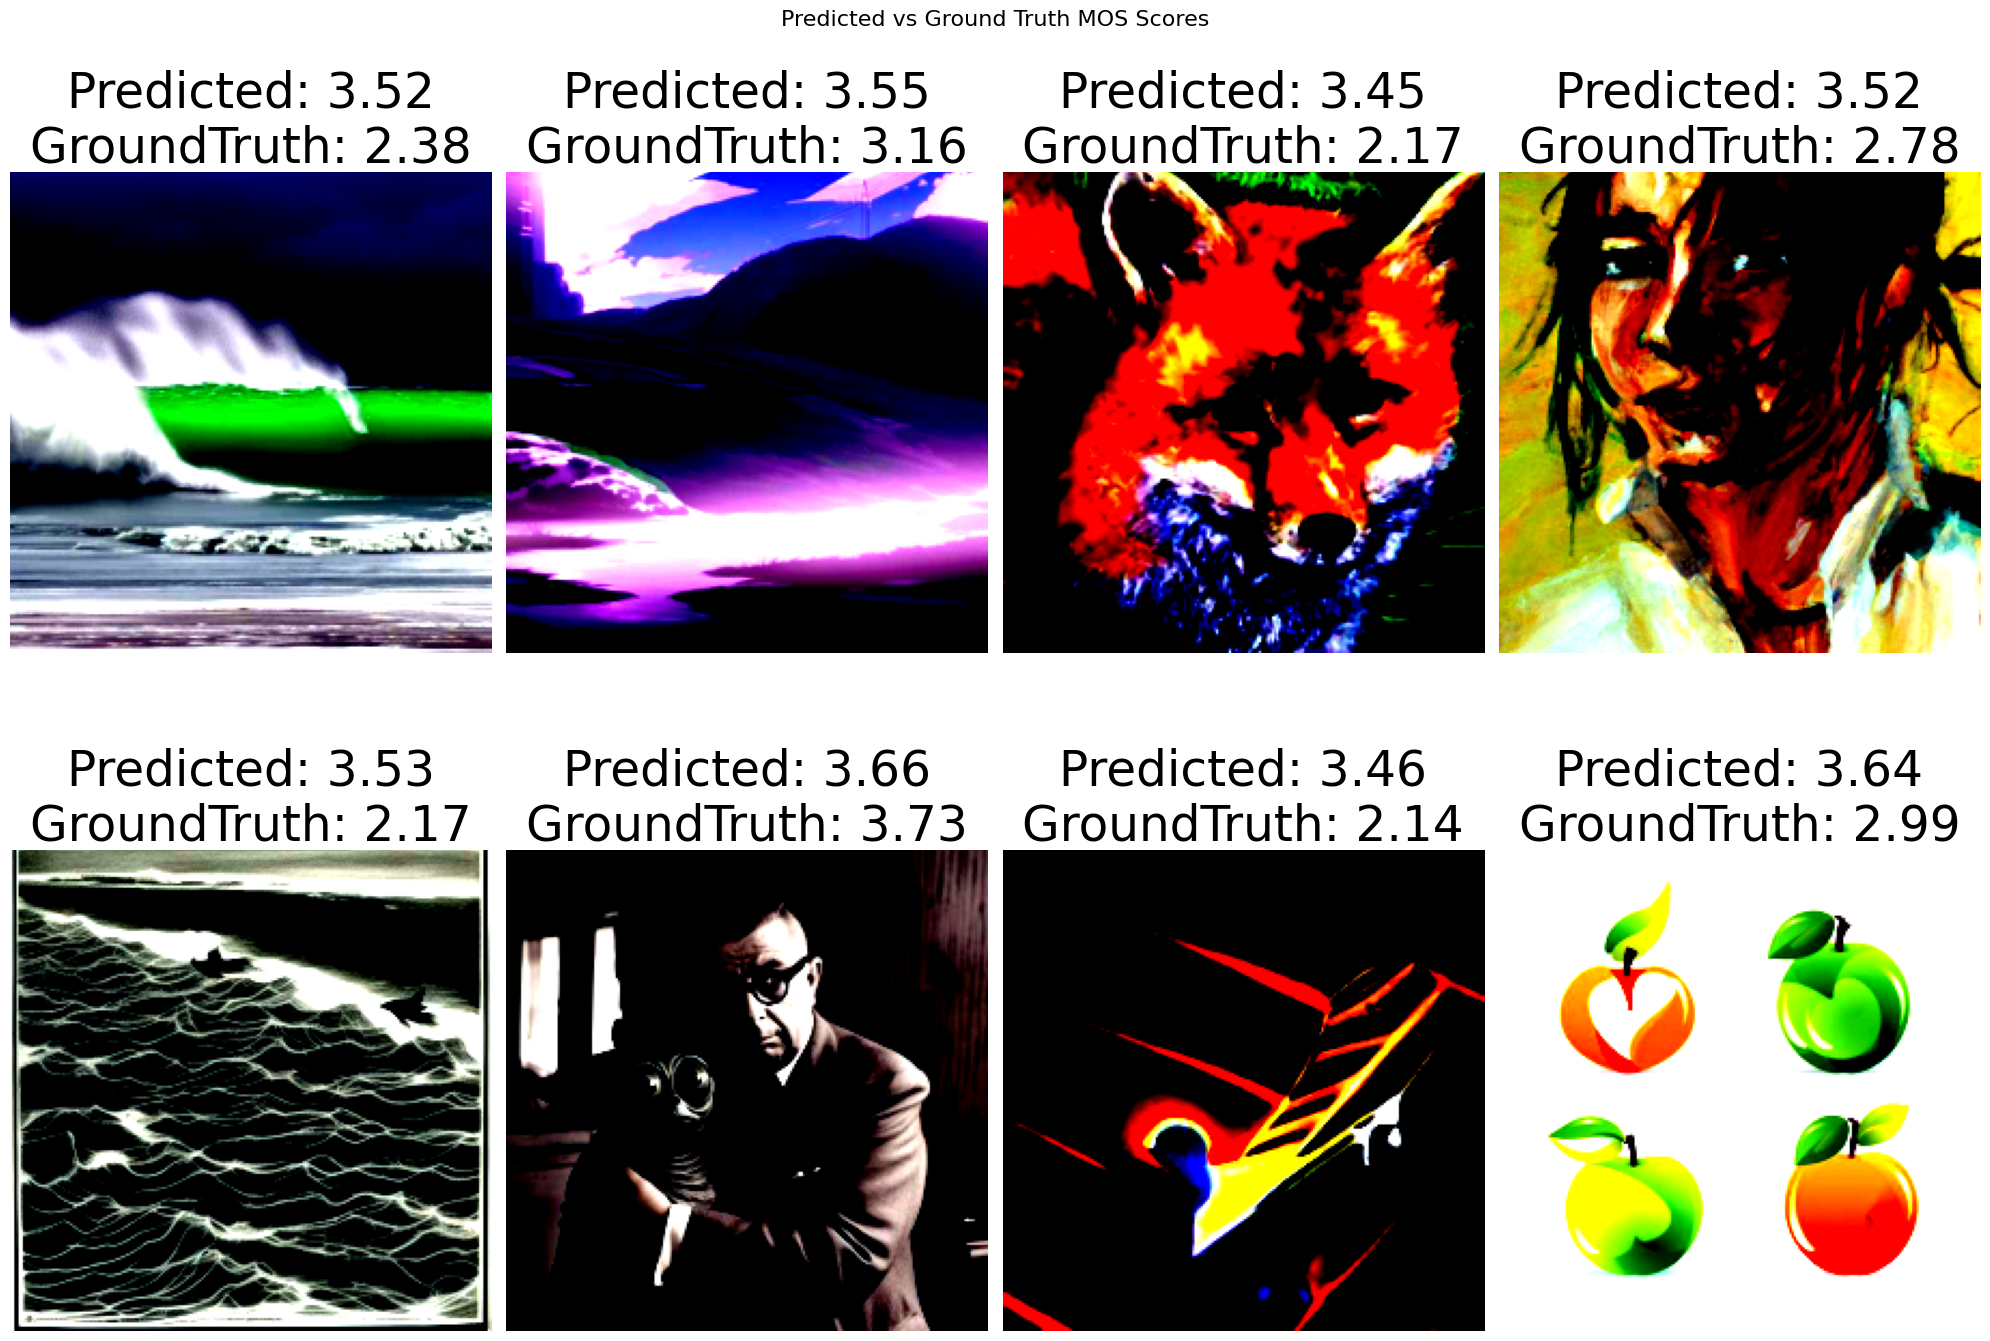

In [ ]:
predict_8_samples_subplot(model, test_loader, task_prompts)

In [63]:
class AIGIDataset_align(Dataset):
#     def __init__(self, csv_file, img_dir, transform=None):
    def __init__(self, data_df, img_dir, transform=None):
        """
        Args:
            csv_file (str): Path to CSV file with image paths, prompts, and MOS scores.
            img_dir (str): Directory containing images.
            transform: Image transformations.
        """
#         self.data = pd.read_csv(csv_file)
        self.data = data_df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx]["name"])
        image = Image.open(img_name).convert("RGB")
        
        # Initial prompt
        initial_prompt = self.data.iloc[idx]["prompt"]
        
        # MOS score (quality score)
        mos_score = float(self.data.iloc[idx]["mos_align"])
        # print(mos_score)
        if self.transform:
            image = self.transform(image)
        
        return {
            "image": image,
            "initial_prompt": initial_prompt,
            "mos_score": mos_score
        }

In [64]:
test_dataset = AIGIDataset_align(
    #csv_file="./AIGIQA-3k/AIGIQA-3k/data.csv",
    data_df = test_df,
    img_dir=r"AIGIQA-3k/AIGIQA-3k/AGIQA-3K",
    transform=transform
)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_align = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [65]:
print("Starting testing...")
srcc, plcc, predictions, ground_truths = test_model(trained_model, test_loader_align, task_prompts)
print(f"SRCC: {srcc:.4f}, PLCC: {plcc:.4f}")

Starting testing...
SRCC: 0.7746, PLCC: 0.8399


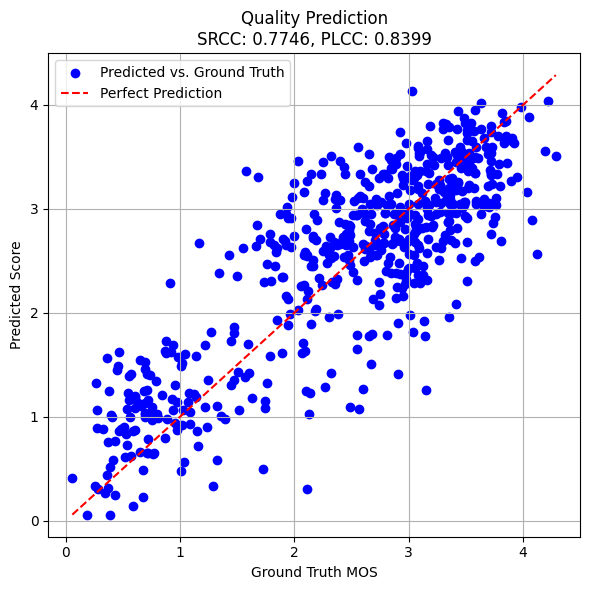

In [68]:
import matplotlib.pyplot as plt

# Run test
# srcc, plcc, predictions, ground_truths = test_model(model, test_loader, task_prompts)
# print(f"SRCC: {srcc:.4f}, PLCC: {plcc:.4f}")

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(ground_truths, predictions, c='blue', label='Predicted vs. Ground Truth')
plt.plot([min(ground_truths), max(ground_truths)], [min(ground_truths), max(ground_truths)],
         'r--', label='Perfect Prediction')
plt.xlabel('Ground Truth MOS')
plt.ylabel('Predicted Score')
plt.title(f'Quality Prediction\nSRCC: {srcc:.4f}, PLCC: {plcc:.4f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

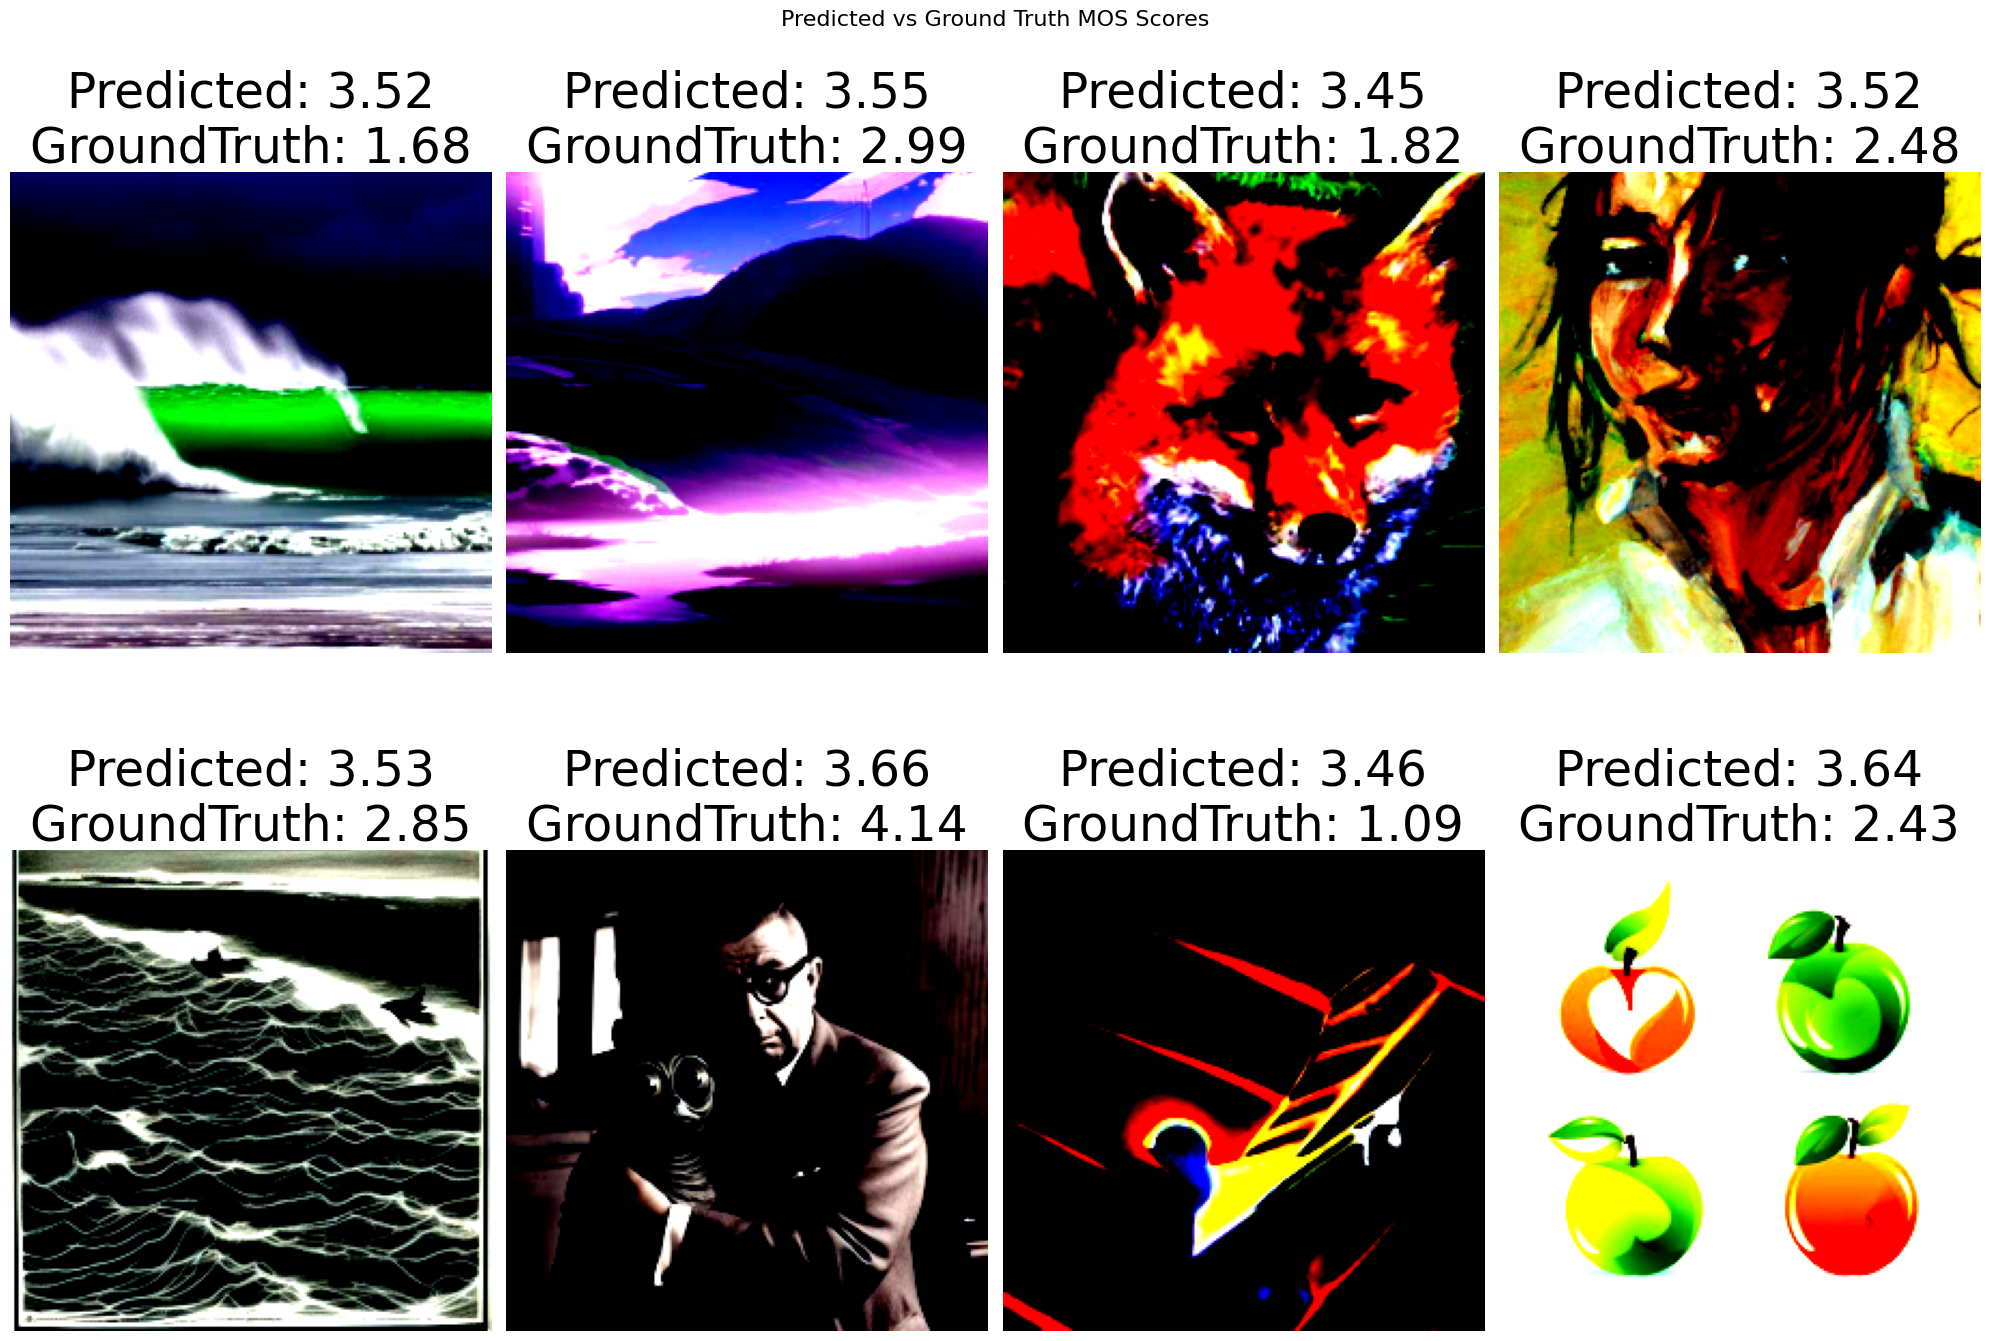

In [ ]:
predict_8_samples_subplot(model, test_loader_align, task_prompts)